In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 28 22:03:31 2020

@author: nathanl

"""

#import the necessary stuff
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.interpolate import InterpolatedUnivariateSpline
from ripser import ripser
from persim import plot_diagrams
import scipy.io.wavfile
from IPython.display import clear_output
from IPython.display import Audio
from MusicFeatures import *
import librosa
import librosa.display
import os
import pickle
import gc
import persim
import CSMSSMTools
from densityChecked import densityChecked
import time
import sklearn

In [3]:
# These work

def get_waveform(file_name, should_plot = False):
    #load in song and display it as waveform
    Fs, X = scipy.io.wavfile.read(file_name)
    X = X/(2.0**15) #in as 16 bit shorts, convert to float
    if(should_plot) :
        plt.figure()
        plt.plot(np.arange(len(X))/float(Fs), X)
        plt.xlabel("Time (secs)")
        plt.title("Song Name")
        plt.show()
    return Fs, X

def get_all_waveforms(filepaths):
    sampling_rates = []
    waveforms = []
    for path in filepaths:
        print(path)
        Fs, X = get_waveform(path)
        sampling_rates.append(Fs)
        waveforms.append(X)
    return sampling_rates, waveforms

In [4]:
# Works fine

#sliding window, assuming integer x, dim, Tau
def slidingWindowInt(x, dim, Tau, dT, duration = 3, mono = True):
    N = len(x)
    numWindows = int(np.floor((N-dim*Tau)/dT)) #number of windows
    if numWindows <= 0:
        print("Error: Tau too large")
        return np.zeros((duration, dim))
    X = np.zeros((numWindows, dim)) #2D array to store the windows
    idx = np.arange(N)
    for i in range(numWindows):
        #indices of the samples in window
        idxx = np.array(dT*i + Tau*np.arange(dim), dtype=np.int32)
        # This changes based on whether you have mono or stereo audio
        if(mono):
            X[i, :] = x[idxx]
        else:
            X[i, :] = x[idxx][:,0]
    return X

def get_all_embeddings(X_arr, dim_arr, Tau_arr, dT_arr):
    Y_arr = []
    for i in range(len(X_arr)):
        Y = slidingWindowInt(X_arr[i], dim_arr[i], Tau_arr[i], dT_arr[i])
        print(Y)
        Y_arr.append(Y)
    return Y

In [5]:
# Works fine

def compute_novfn(X, Fs, winSize, hopSize, plot_spectrogram = False, plot_novfn = False):
    #Compute the power spectrogram and audio novelty function
    (S, novFn) = getAudioNoveltyFn(X[:,0], Fs, winSize, hopSize)
        
    if plot_spectrogram:    
        plt.figure()
        plt.imshow(np.log(S.T), cmap = 'afmhot', aspect = 'auto')
        plt.title('Log-frequency power spectrogram')
        plt.show() 

    if plot_novfn:              
        plt.figure(figsize=(8, 4))
        #Plot the spectrogram again
        plt.subplot(211)
        plt.imshow(np.log(S.T), cmap = 'afmhot', aspect = 'auto')
        plt.ylabel('Frequency Bin')
        plt.title('Log-frequency power spectrogram')

        #Plot the audio novelty function
        plt.subplot(212)
        plt.plot(np.arange(len(novFn))*hopSize/float(Fs), novFn)
        plt.xlabel("Time (Seconds)")
        plt.ylabel('Audio Novelty')
        plt.xlim([0, len(novFn)*float(hopSize)/Fs])
        plt.show()

    return S,novFn

def compute_all_novfn(X_arr, Fs_arr, winSizes, hopSizes):
    S_arr = []
    novFn_arr = []
    for i in range(len(X_arr)):
        X = X_arr[i]
        Fs = Fs_arr[i]
        winSize = winSizes[i][0]
        hopSize = hopSizes[i][0]
        S, novFn = compute_novfn(X, Fs, winSize, hopSize)
        S_arr.append(S)
        novFn_arr.append(novFn)
    return S_arr, novFn_arr

In [6]:
def compute_chroma(X, Fs):
    chroma = librosa.feature.chroma_stft(X[:,0], Fs)
    return chroma

# Not used anywhere
def compute_all_chroma(X_arr, Fs_arr):
    chroma_arr = []
    for i in range(len(X_arr)):
        chroma_arr.append(compute_chroma(X_arr[i], Fs[i]))
    return chroma_arr

In [7]:
# Works fine

# Y is the data, dim is the MAX dimensional homology we want to compute
def compute_pd(Y, dim = 1, plot_points = True, plot_dgm = True, filter_by_density = False):
    # Mean-center and normalize
    print(Y.shape)
    Y = Y - np.mean(Y, 1)[:, None]
    # Cheating a little here
    Y = Y/np.sqrt(np.sum(Y**2, 1)+1)[:, None]
    PDs = ripser(Y, dim)['dgms']
    pca = PCA()
    Z = pca.fit_transform(Y)

    #print(pca.explained_variance_ratio_)

    # Plot point cloud and persistence diagram for song
    plt.figure(figsize=(8, 4))    
    if(plot_points):
        plt.subplot(121)
        plt.title("2D PCA")
        plt.scatter(Z[:, 0], Z[:, 1])
    if(plot_dgm):
        plt.subplot(122)
        plot_diagrams(PDs)
        # Below line doesn't work since I refactored code
        #plt.title("Persistence Diagram, dim = "+str(dim)+" tau = "+str(Tau) + "dT" + str(dT))
    if(plot_points or plot_dgm):
        plt.show()

    return PDs 

# This dimension actually means specifically the dimension of homology feature you want
def compute_all_pds(Y_arr, dim = 1):
    dgms = []
    for Y in Y_arr:
        PDs = compute_pd(Y, dim, plot_points = False, plot_dgm = False)
        dgms.append(PDs[dim])
    return dgms

In [8]:
# Starts from scratch
# Compute persistence diagrams corresponding to one song (one for each segment)
# Valid feature types: novfn, chroma
def compute_pds_for_specific_song_split(X, Fs, song_name, splits, split_num, tempo, dim = 20, dT = 2, store = True, feature_type = "novfn", chroma_num = 0):
    if split_num == 0:
            start_point = 0
    else:
        start_point = Fs*splits[split_num-1]
    if split_num == len(splits):
        end_point = len(X)
    else:
        end_point = Fs*splits[split_num]
    
    windowSize = 512
    hopSize = 256
    
    if(end_point - start_point > 30):
        windowSize = 1024
        hopSize = 512
    
    if(end_point - start_point > 60):
        windowSize = 2048
        hopSize = 1024
    
    if(feature_type == "novfn"):
        # Compute novelty function
        S, novFn = compute_novfn(X[start_point:end_point], Fs, windowSize, hopSize)

        Tau = Fs * 120 /(hopSize * dim * tempo)
        Y = slidingWindowInt(novFn, dim, Tau, dT)

    if(feature_type == "chroma"):
        hopSize *= 8
        # For some reason we get stereo here
        chroma = librosa.feature.chroma_stft(X[start_point:end_point,0], Fs, hop_length = 512)
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
        plt.colorbar()
        plt.title('Chromagram')
        plt.tight_layout()
        dim = 20
        Tau = Fs * 240 /(hopSize * dim * tempo)
        dT = 2
        print(chroma.shape)
        Y = slidingWindowInt(chroma[chroma_num,:], dim, Tau, dT)
        
    dgms = compute_pd(Y)
    
    # Store pickle of matrix for persistence diagram
    if(store):
        savepath = song_name + "_" + str(start_point) + "_"  + str(end_point)
        
        if(feature_type == "chroma"):
            savepath = "chroma_"+str(chroma_num)+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)+"_chroma"+str(chroma_num)
        
        outfile = open(savepath, "wb")
        pickle.dump(dgms, outfile)
        outfile.close()
    return dgms 

# Input splits as timestamps
def compute_pds_for_full_song(X, Fs, song_name, splits, tempo, dim = 20, dT = 2, store = True, feature_type = "novfn"):
    all_dgms = []
    for i in range(len(splits)+1):
        if(feature_type == "novfn"):
            dgms = compute_pds_for_specific_song_split(X,Fs, song_name, splits, i, tempo, dim, dT, store, feature_type)  
            all_dgms.append(dgms)
        if(feature_type == "chroma"):
            for chroma_num in range(12):
                dgms = compute_pds_for_specific_song_split(X,Fs, song_name, splits, i, tempo, dim, dT, store, feature_type, chroma_num)  
                all_dgms.append(dgms)
            
    return all_dgms

# segments should be fed in as arrays of arrays of size two consisting of start and end point
# Start and end point should be fed in as array indices
def compute_pds_from_filepath(song_name, song_filepath, splits, tempo, dim = 20, dT = 2, store = True, feature_type = "novfn"):
    # Get waveform
    Fs, waveform = get_waveform(song_filepath)
    
    endpoint = len(waveform)

    all_dgms = compute_pds_for_full_song(waveform, Fs, song_name, splits, tempo, dim, dT, store, feature_type)
        
    return all_dgms, endpoint


For each song or song snippet
1. Compute waveform and sampling rate
2. Compute window size and hop size
3. Compute novelty function
4. Compute persistence diagram
5. Store persistence diagram
6. Clear data

Then finally,

7. Compute the clusters

In [9]:
path = os.path.abspath("Lady Gaga - Shape Features.ipynb")
path = os.path.dirname(path)

# Step 1

famemonster_song_names = ['01 - Bad Romance [Explicit]', '02 - Alejandro', '03 - Monster [Explicit]', 
'04 - Speechless', '05 - Dance In The Dark [Explicit]', '06 - Telephone [feat. Beyoncé]', '07 - So Happy I Could Die', 
'08 - Teeth [Explicit]', "(Disc 2) 01 - Just Dance [feat. Colby O_Donis]", '(Disc 2) 02 - LoveGame', 
'(Disc 2) 04 - Poker Face', '(Disc 2) 07 - The Fame', '(Disc 2) 09 - Starstruck [feat. Space Cowboy _ Flo Rida]',
'(Disc 2) 11 - Paper Gangsta [Explicit]', '(Disc 2) 12 - Brown Eyes', '(Disc 2) 13 - I Like It Rough',
'(Disc 2) 14 - Summerboy', '(Disc 2) 15 - Disco Heaven']

famemonster_filepaths = []

for i in range(len(famemonster_song_names)):
    famemonster_filepaths.append(path + '\\..\\FameMonster\\' + famemonster_song_names[i] + ".wav") 

# Missing Do What U Want for some reason
artpop_song_names = ['01 - Aura [Explicit]', '02 - Venus [Explicit]', '03 - G.U.Y. [Explicit]', '04 - Sexxx Dreams [Explicit]', 
'05 - Jewels N_ Drugs [feat. T.I. _ Too $hort _ Twista] [Explicit]', '06 - MANiCURE', '07 - ARTPOP',
'08 - Swine [Explicit]', '09 - Donatella [Explicit]', '10 - Fashion!', '11 - Mary Jane Holland [Explicit]',
'12 - Dope [Explicit]', '13 - Gypsy', '14 - Applause']

artpop_filepaths = []

for i in range(len(artpop_song_names)):
    artpop_filepaths.append(path + '\\..\\Artpop\\' + artpop_song_names[i] + ".wav") 
    
chromatica_song_names = ['01 Chromatica I', '02 Alice', '03 Stupid Love', '04 Rain On Me', '05 Free Woman',
'06 Fun Tonight', '07 Chromatica II', '08 911', '09 Plastic Doll', '10 Sour Candy', '11 Enigma', '12 Replay',
'13 Chromatica III', '14 Sine From Above', '15 1000 Doves', '16 Babylon']

chromatica_filepaths = []

for i in range(len(chromatica_song_names)):
    chromatica_filepaths.append(path + '\\..\\Chromatica\\' + chromatica_song_names[i] + ".wav") 

    
famemonster_song_splits = [
    # 1 - Bad Romance
    [18, 26, 34, 66, 74, 106, 115, 147, 155, 187, 203, 220, 235, 250, 284, 292],
    # 2 - Alejandro
    [15, 26, 35, 44, 64, 73, 113, 123, 142, 152, 190, 210, 229, 248, 268],
    # 3 - Monster
    [10, 17, 25, 33, 49, 66, 81, 84, 97, 114, 129, 145, 148, 162, 177, 193, 202, 212, 229, 245],
    # 4 - Speechless
    [15, 42, 55, 82, 123, 149, 174, 196, 204, 230, 263, 267],
    # 5 Dance in the Dark
    [18, 33, 49, 77, 79, 110, 136, 156, 205, 220, 227, 239, 258, 273, 285],
    # 6 Telephone
    [9, 25, 33, 49, 64, 80, 96, 112, 120, 127, 135, 167, 182, 199, 214],
    # 7 So Happy I could Die
    [20, 39, 59, 78, 97, 117, 136, 145, 155, 164, 174, 193, 204, 231],
    # 8 Teeth
    [11, 22, 61, 82, 121, 140, 152, 172, 191, 201],
    # 1 Just Dance
    [6, 9, 17, 33, 50, 68, 84, 100, 116, 133, 148, 156, 174, 180, 197, 212, 221, 237],
    # 2 Love Game
    [10, 17, 37, 46, 55, 73, 81, 101, 110, 119, 137, 146, 165, 173, 197],
    # 4 Poker Face
    [9, 18, 26, 33, 41, 58, 74, 82, 90, 98, 114, 130, 138, 146, 155, 163, 171, 211],
    # 7 The Fame
    [4, 11, 19, 34, 49, 64, 79, 110, 125, 140, 155, 163, 170, 201],
    # 9 Starstruck
    [20, 38, 58, 76, 94, 132, 150, 169, 187, 211],
    # 11 Paper Gangsta
    [11, 20, 40, 47, 67, 87, 106, 115, 135, 145, 182, 193, 223, 252],
    # 12 Brown Eyes
    [8, 25, 55, 82, 130, 157, 173, 202, 220, 237],
    # 13 I like it Rough
    [9, 25, 41, 57, 73, 89, 104, 120, 138, 153, 184],
    # 14 Summerboy
    [13, 31, 49, 67, 77, 113, 136, 172, 218],
    # 15 Disco Heaven
    [15, 45, 75, 105, 135, 166, 197, 212]
    
]    
# An array of arrays, where subarray corresponds to splits for a given song
artpop_song_splits = [
    # 1 - Aura
    [9, 34, 56, 67, 72, 100, 137, 152, 167, 182, 215, 219],
    # 2- Venus
    [7, 40, 56, 72, 88, 104, 120, 134, 152, 167, 199, 215],
    # 3 GUY
    [18, 27, 45, 53, 62, 80, 88, 105, 121, 140, 158, 186, 220, 230],
    # 4 Sexxx Dreams
    [5, 34, 51, 56, 72, 106, 118, 140, 159, 177, 211],
    # 5 Jewels N Drugs
    [6, 20, 51, 65, 93, 107, 136, 163, 217],
    # 6 Manicure
    [16, 29, 43, 57, 85, 112, 120, 134, 148, 168],
    # 7 Artpop
    [18, 50, 85, 90, 122, 155, 172, 204, 237],
    # 8 Swine
    [9, 38, 67, 97, 127, 157, 187, 202, 217, 232, 247],
    # 9 Donatella
    [4, 8, 19, 50, 65, 81, 97, 141, 157, 172, 187, 203, 218, 249],
    # 10 Fashion
    [17, 35, 68, 100, 126, 149, 168, 184, 200],
    # 11 Mary Jane Holland
    [10, 48, 67, 86, 105, 123, 142, 161, 210, 248, 268, 275],
    # 12 Dope
    [16, 93,  108, 153, 186, 197],
    # 13 Gypsy
    [30, 45, 58, 73, 102, 116, 130, 144, 161, 171, 194, 202, 216, 231, 244],
    # 14 - Applause
    [15,56,70,83,109,143,151,164,178, 208]
]

chromatica_song_splits = [
    # Chromatica I
    [],
    # Alice
    [18, 34, 50, 65, 96, 112, 129, 143],
    # Stupid Love
    [9, 26, 41, 57, 74, 90, 108, 122, 140, 156],
    # Rain on Me
    [16, 32, 41, 46, 64, 80, 95, 109, 127, 143, 148, 166, 173],
    # Free Woman
    [9, 41, 58, 73, 91, 122, 138, 155, 170, 186],
    # Fun Tonight
    [4, 20, 36, 52, 68, 87, 102, 118, 134, 152, 172],
    # Chromatica II
    [31],
    # 911
    [9, 26, 35, 41, 59, 75, 84, 92, 108, 117, 131, 150, 167],
    # Plastic Doll
    [9, 17, 49, 63, 81, 96, 112, 144, 152, 160, 169, 202, 217],
    # Sour Candy
    [8, 10, 17, 33, 64, 81, 90, 110, 125, 142, 150],
    # Enigma
    [5, 22, 34, 48, 66, 83, 94, 112, 128, 140, 145, 174],
    # Replay
    [13, 21, 39, 55, 71, 88, 104, 122, 136, 151, 183],
    # Chromatica III
    [],
    # Sine from above
    [9, 40, 56, 71, 85, 87, 103, 119, 133, 149, 165, 178, 180, 195, 203, 209, 215, 221, 241],
    # 1000 Doves
    [17, 34, 48, 64, 80, 96, 111, 127, 143, 166, 182, 213],
    # Babylon
    [6, 10, 26, 32, 42, 50, 65, 67, 83, 89, 91, 106, 110, 124, 141, 155, 158]
]


In [10]:
# Step 2

# In beats per minute
# Do not have all the songs for famemonster
famemonster_tempos = [117,98,119,144,121, 122, 99, 96, 119, 104, 120, 132, 103, 112, 60, 120, 105, 128]
artpop_tempos = [129,121,110,113,136,138,117,127,124,116,101,128,133,139]
chromatica_tempos = [75,123,117,123,117,117,75,117,121,120,117,123,121,122,123,117]



In [11]:
# This is lazy, but works - imports all the correct stuff based on the feature type
Fs = 44100
def load_all_pds(song_names, split_points, endpoints, feature_type = "novfn", chroma_num =0):
    pds = []
    for song in range(len(song_names)):
        for split_num in range(len(split_points[song])+1):
            song_name = song_names[song]
            if split_num == 0:
                start_point = 0
            else:
                start_point = Fs * split_points[song][split_num-1]
            if split_num == len(split_points[song]):
                end_point = endpoints[song]
            else:
                end_point = Fs * split_points[song][split_num]
            if feature_type == "novfn":
                savepath = "novfn\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            if feature_type == "chroma":
                savepath = "chroma_"+chroma_num+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            with open(savepath, 'rb') as f:
                pds.append(pickle.load(f))
    gc.collect()
    return pds

def load_pds_grouped_by_song(song_names, split_points, endpoints, feature_type = "novfn", chroma_num =0):
    pds_by_song = []
    for song in range(len(song_names)):
        song_pds = []
        for split_num in range(len(split_points[song])+1):
            song_name = song_names[song]
            if split_num == 0:
                start_point = 0
            else:
                start_point = Fs * split_points[song][split_num-1]
            if split_num == len(split_points[song]):
                end_point = endpoints[song]
            else:
                end_point = Fs * split_points[song][split_num]
            if feature_type == "novfn":
                savepath = "novfn\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            if feature_type == "chroma":
                savepath = "chroma_"+chroma_num+"\\"+song_name + "_" + str(start_point) + "_"  + str(end_point)
            with open(savepath, 'rb') as f:
                song_pds.append(pickle.load(f))
        pds_by_song.append(song_pds)
        gc.collect()
    return pds_by_song

In [12]:
# Loads in all the persistence diagrams from the files

famemonster_pds = []
artpop_pds = []
chromatica_pds = []

with open("famemonster_endpoints", 'rb') as f:
    famemonster_endpoints = pickle.load(f)

famemonster_pds = load_all_pds(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)

with open("artpop_endpoints", 'rb') as f:
    artpop_endpoints = pickle.load(f)

artpop_pds = load_all_pds(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names,artpop_song_splits, artpop_endpoints)

with open("chromatica_endpoints", 'rb') as f:
    chromatica_endpoints = pickle.load(f)

chromatica_pds = load_all_pds(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)


In [13]:
'''
pds_by_song is an array containing one array for each song. The array for each song contains 
arrays of size two corresponding to the zeroth and first homologies respectively. 

segment_indices_by_song is an array containing one array for each song. The array for each song
contains arrays corresponding to the indices of whatever segment type you want (chorus, verse, etc)
for that song
'''
def get_pds_by_indices(pds_by_song, segment_indices_by_song):
    pds_at_indices = []
    for song_index in range(len(pds_by_song)):
        sliced_pds_by_song = []
        for segment_index in segment_indices_by_song[song_index]:
#            if(len(pds_by_song[song_index]) == 0):
#                print(pds_by_song[song_index])
            pds = pds_by_song[song_index][segment_index]
            sliced_pds_by_song.append(pds)
        pds_at_indices.append(sliced_pds_by_song)
    return pds_at_indices

In [14]:
# Each subarray is set of indices for clips for a song

famemonster_intro_indices = [
    # 1 - Bad Romance
    [0],
    # 2 - Alejandro
    [0],
    # 3 - Monster
    [0],
    # 4 - Speechless
    [0],
    # 5 Dance in the Dark
    [0],
    # 6 Telephone
    [0],
    # 7 So Happy I could Die
    [0],
    # 8 Teeth
    [0],
    # 1 Just Dance
    [0],
    # 2 Love Game
    [0],
    # 4 Poker Face
    [0],
    # 7 The Fame
    [0],
    # 9 Starstruck
    [0],
    # 11 Paper Gangsta
    [0],
    # 12 Brown Eyes
    [0],
    # 13 I like it Rough
    [0],
    # 14 Summerboy
    [0],
    # 15 Disco Heaven
    [0]
]    

artpop_intro_indices = [
    # 1 - Aura
    [0],
    # 2- Venus
    [0],
    # 3 GUY
    [0],
    # 4 Sexxx Dreams
    [0],
    # 5 Jewels N Drugs
    [0],
    # 6 Manicure
    [0],
    # 7 Artpop
    [0],
    # 8 Swine
    [0],
    # 9 Donatella
    [0],
    # 10 Fashion
    [0],
    # 11 Mary Jane Holland
    [0],
    # 12 Dope
    [0],
    # 13 Gypsy
    [0],
    # 14 - Applause
    [0]
]

chromatica_intro_indices = [
    # 1 Chromatica I
    [0],
    # 2 Alice
    [0],
    # 3 Stupid Love
    [0],
    # 4 Rain on Me
    [0],
    # 5 Free Woman
    [0],
    # 6 Fun Tonight
    [0],
    # 7 Chromatica II
    [0],
    # 8 911
    [0],
    # 9 Plastic Doll
    [0],
    # 10 Sour Candy
    [0],
    # 11 Enigma
    [0],
    # 12 Replay
    [0],
    # 13 Chromatica III
    [0],
    # 14 Sine from above
    [0],
    # 15 1000 Doves
    [0],
    # 16 Babylon
    [0]
]

In [15]:
famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_intro_pds = get_pds_by_indices(famemonster_pds_by_song, famemonster_intro_indices)

artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_intro_pds = get_pds_by_indices(artpop_pds_by_song, artpop_intro_indices)

chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_intro_pds = get_pds_by_indices(chromatica_pds_by_song, chromatica_intro_indices)


In [74]:
# Works fine given the correct input

# The list of diagrams is by song and then by segments and then by dgms
def compute_distance_matrix(famemonster_dgms_by_song, artpop_dgms_by_song, chromatica_dgms_by_song, savepath, plot_clusters = True):
    # Just throw away song level data for now, just get an array of actual segments
    famemonster_dgms = []
    for song in famemonster_dgms_by_song:
        for segment in song:
            famemonster_dgms.append(segment[1])
    artpop_dgms = []
    for song in artpop_dgms_by_song:
        for segment in song:
            artpop_dgms.append(segment[1])
    chromatica_dgms = []
    for song in chromatica_dgms_by_song:
        for segment in song:
            chromatica_dgms.append(segment[1])
    
    all_dgms = np.concatenate([famemonster_dgms, artpop_dgms, chromatica_dgms])
    num_dgms = len(all_dgms)
    print(num_dgms)
    famemonster_length = len(famemonster_dgms)
    print("Famemonster length: " + str(famemonster_length))
    artpop_length = len(artpop_dgms)
    chromatica_length = len(chromatica_dgms)
    
    with open(savepath, 'rb') as f:
        distance_matrix = pickle.load(f)

    # Compute the distance matrix
    if(distance_matrix.shape[0] != num_dgms):
        distance_matrix = np.zeros([num_dgms,num_dgms])
        
    for i in range(num_dgms):
        for j in range(i,num_dgms):
            if(np.abs(distance_matrix[i][j]) > 1e-2):
                continue
            if i == j:
                distance_matrix[i][i] = 0
            else:
                print(i)
                print(j)
                start = time.time()
                distance_matrix[i][j] = persim.bottleneck(all_dgms[i], all_dgms[j])
                end = time.time()
                print(end-start)
            gc.collect()

            outfile = open(savepath, "wb")
            pickle.dump(distance_matrix, outfile)
            outfile.close()
    
    return distance_matrix



In [125]:
def compute_mds(distance_matrix, famemonster_length, artpop_length, chromatica_length, title = ''):
    embedding = sklearn.manifold.MDS(n_components = 2, random_state = 0, dissimilarity = 'precomputed')        
    coords = embedding.fit_transform(distance_matrix)
    x = coords[:,0]
    y = coords[:,1]
    print(len(x))

    # Album labels for the songs
    album = np.concatenate([np.full((famemonster_length,1), 0), np.full((artpop_length,1), 1), np.full((chromatica_length,1), 2)])
    
    # Do kmeans clustering and get labels
    kmeans = sklearn.cluster.KMeans(n_clusters = 3, n_init = 20).fit(coords)
    cluster_labels = kmeans.labels_
    print(cluster_labels)
    #print("I should have "+str(famemonster_length + artpop_length + chromatica_length)+"labels and I really have "+str(len(cluster_labels)))
    #plt.scatter(x,y,c=cluster_labels)
    
    plt.figure()
    for i in range(len(x)):
        if cluster_labels[i] == 0:
            color = "orange"
        if cluster_labels[i] == 1:
            color = "blue"
        if cluster_labels[i] == 2:
            color = "green"
        if i < famemonster_length:
            label = 'Fame Monster'
            marker = 'o'
        elif i < famemonster_length + artpop_length:
            label = 'Artpop'
            marker = 'x'
        elif i < famemonster_length + artpop_length + chromatica_length:
            label = 'Chromatica'
            marker = '+'
        plt.scatter(x[i], y[i], c = color, marker = marker, label = label)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.title(title)
    plt.show()
        
    '''
    # This is not a particularly elegant solution, but the simplest way I could get it to plot both different colors and different markers
    x_famemonster = x[:famemonster_length]
    y_famemonster = y[:famemonster_length]
    labels_famemonster = cluster_labels[:famemonster_length]
    
    print(labels_famemonster)
    x_artpop = x[famemonster_length:famemonster_length+artpop_length]
    y_artpop = y[famemonster_length:famemonster_length+artpop_length]
    labels_artpop = cluster_labels[famemonster_length:famemonster_length+artpop_length]
    x_chromatica = x[famemonster_length + artpop_length:famemonster_length+artpop_length + chromatica_length]
    y_chromatica = y[famemonster_length + artpop_length:famemonster_length+artpop_length + chromatica_length]
    labels_third_album = cluster_labels[famemonster_length + artpop_length:famemonster_length+artpop_length + chromatica_length]
    
    plt.figure()
    plt.scatter(x_famemonster, y_famemonster, c = labels_famemonster, marker = 'o', label = "Fame Monster")
    plt.scatter(x_artpop, y_artpop, c = labels_artpop, marker = 'x', label = 'Artpop')
    plt.scatter(x_chromatica, y_chromatica, c = labels_third_album, marker = '+', label = 'Chromatica')
    '''

In [114]:
def get_length_from_pds_by_song(pds_by_song):
    length = 0
    for song in pds_by_song:
        for segment in song:
            length += 1
    return length

In [117]:
print(get_length_from_pds_by_song(famemonster_prechorus_pds) + get_length_from_pds_by_song(artpop_prechorus_pds) + get_length_from_pds_by_song(chromatica_prechorus_pds))

79


[[0.         0.06839326 0.06557852 ... 0.07719171 0.09576464 0.10767353]
 [0.06839326 0.         0.08778057 ... 0.08778057 0.1167475  0.10195905]
 [0.06557852 0.08778057 0.         ... 0.05785918 0.13588148 0.09254164]
 ...
 [0.07719171 0.08778057 0.05785918 ... 0.         0.13309741 0.09597385]
 [0.09576464 0.1167475  0.13588148 ... 0.13309741 0.         0.18392104]
 [0.10767353 0.10195905 0.09254164 ... 0.09597385 0.18392104 0.        ]]
18
14
16
48
[0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 0 0 0 1 0 0 2 0 0 1 0 1
 0 0 1 1 0 1 0 0 0 0 0]


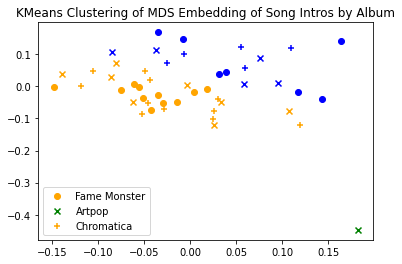

In [126]:
with open("intros_distance_matrix", 'rb') as f:
    distance_matrix = pickle.load(f)
print(distance_matrix)
print(len(famemonster_intro_pds))
print(len(artpop_intro_pds))
print(len(chromatica_intro_pds))
compute_mds(distance_matrix, get_length_from_pds_by_song(famemonster_intro_pds), get_length_from_pds_by_song(artpop_intro_pds), get_length_from_pds_by_song(chromatica_intro_pds), title = "KMeans Clustering of MDS Embedding of Song Intros by Album")

[[0.         0.17539537 0.0684163  ... 0.17810297 0.2440837  0.13067245]
 [0.17539537 0.         0.11577004 ... 0.14550865 0.13115376 0.12241137]
 [0.0684163  0.11577004 0.         ... 0.19992393 0.18354848 0.1334393 ]
 ...
 [0.17810297 0.14550865 0.19992393 ... 0.         0.25321594 0.13285732]
 [0.2440837  0.13115376 0.18354848 ... 0.25321594 0.         0.21684405]
 [0.13067245 0.12241137 0.1334393  ... 0.13285732 0.21684405 0.        ]]
79
[2 1 2 2 1 0 1 2 1 1 0 2 0 1 0 2 2 0 0 0 0 0 2 0 2 1 0 1 0 1 2 0 2 2 1 1 1
 1 1 1 2 1 1 2 1 2 2 1 0 1 2 1 2 1 2 0 1 2 2 2 2 0 0 2 1 1 1 2 2 2 1 1 1 0
 1 1 0 1 1]


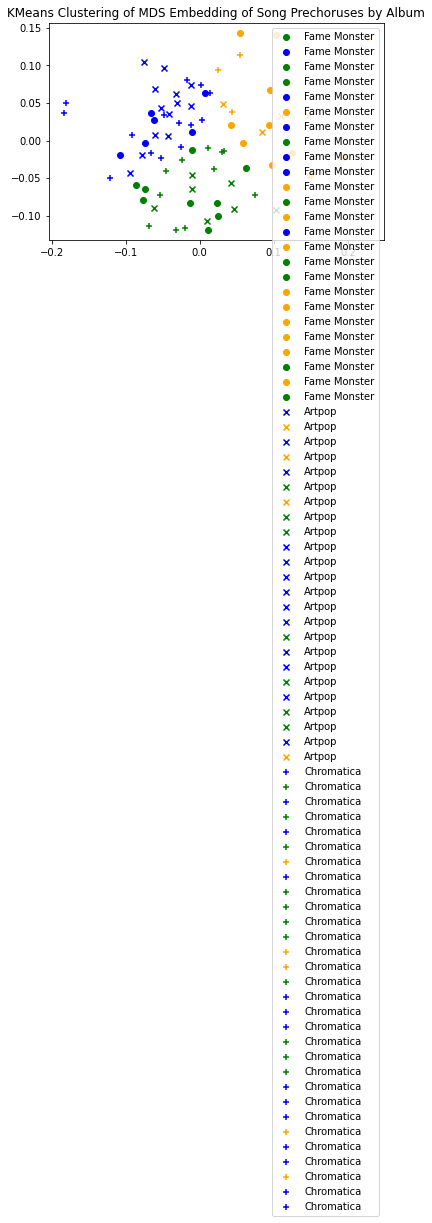

In [124]:
with open("prechorus_distance_matrix", 'rb') as f:
    distance_matrix = pickle.load(f)

print(distance_matrix)
compute_mds(distance_matrix, get_length_from_pds_by_song(famemonster_prechorus_pds), get_length_from_pds_by_song(artpop_prechorus_pds), get_length_from_pds_by_song(chromatica_prechorus_pds), title = "KMeans Clustering of MDS Embedding of Song Prechoruses by Album")


[[0.         0.17484492 0.19371611 ... 0.18164653 0.18164653 0.1823715 ]
 [0.17484492 0.         0.27007461 ... 0.06036699 0.06006214 0.28371662]
 [0.19371611 0.27007461 0.         ... 0.27800602 0.27800602 0.12344086]
 ...
 [0.18164653 0.06036699 0.27800602 ... 0.         0.0846045  0.30280098]
 [0.18164653 0.06006214 0.27800602 ... 0.0846045  0.         0.30280098]
 [0.1823715  0.28371662 0.12344086 ... 0.30280098 0.30280098 0.        ]]
18
14
16
99
[2 2 1 2 0 2 0 0 2 0 0 1 2 0 0 0 1 1 2 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 2 1 0
 1 2 0 2 2 0 0 1 1 0 0 0 2 0 0 1 2 2 2 0 2 0 0 0 0 0 2 0 0 0 0 0 1 2 1 2 2
 2 0 0 2 2 2 0 2 1 1 2 1 2 2 2 2 1 0 1 0 2 2 2 2 1]
[2 2 1 2 0 2 0 0 2 0 0 1 2 0 0 0 1 1 2 1 0 0 1 1 1 1 1 0 0 0 0 0 0 1 2 1 0
 1 2]


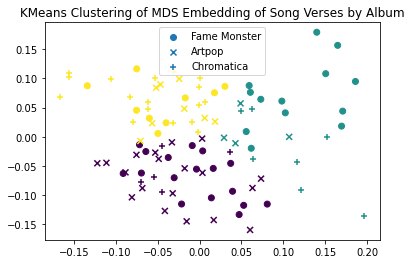

In [118]:
with open("verse_distance_matrix", 'rb') as f:
    distance_matrix = pickle.load(f)

print(distance_matrix)
print(len(famemonster_verse_pds))
print(len(artpop_verse_pds))
print(len(chromatica_verse_pds))
compute_mds(distance_matrix, get_length_from_pds_by_song(famemonster_verse_pds), get_length_from_pds_by_song(artpop_verse_pds), get_length_from_pds_by_song(chromatica_verse_pds), title = "KMeans Clustering of MDS Embedding of Song Verses by Album")


[[0.         0.089863   0.1148752  ... 0.10438299 0.09369177 0.09735984]
 [0.089863   0.         0.13117921 ... 0.10029739 0.12242568 0.09664732]
 [0.1148752  0.13117921 0.         ... 0.09481424 0.0816853  0.13511306]
 ...
 [0.10438299 0.10029739 0.09481424 ... 0.         0.09299159 0.11131096]
 [0.09369177 0.12242568 0.0816853  ... 0.09299159 0.         0.15446711]
 [0.09735984 0.09664732 0.13511306 ... 0.11131096 0.15446711 0.        ]]
18
14
16


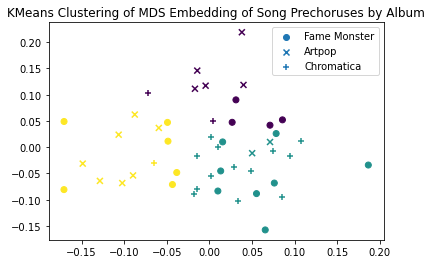

In [96]:
with open("bridge_distance_matrix", 'rb') as f:
    distance_matrix = pickle.load(f)

print(distance_matrix)
print(len(famemonster_bridge_pds))
print(len(artpop_bridge_pds))
print(len(chromatica_bridge_pds))
compute_mds(distance_matrix, len(famemonster_bridge_pds), len(artpop_bridge_pds), len(chromatica_bridge_pds), title = "KMeans Clustering of MDS Embedding of Song Bridges by Album")


In [25]:
# THIS CELL IS A TEMPLATE, REPLACE WITH WHATEVER YOU NEED

# Each subarray is set of indices for clips for a song

famemonster_prechorus_indices = [
    # 1 - Bad Romance
    [4,9,],
    # 2 - Alejandro
    [5,9],
    # 3 - Monster
    [5,9],
    # 4 - Speechless
    [2],
    # 5 Dance in the Dark
    [2,5],
    # 6 Telephone
    [],
    # 7 So Happy I could Die
    [2,6],
    # 8 Teeth
    [],
    # 1 Just Dance
    [4,7],
    # 2 Love Game
    [0,3,4,9],
    # 4 Poker Face
    [5,10],
    # 7 The Fame
    [4],
    # 9 Starstruck
    [1,8],
    # 11 Paper Gangsta
    [3,7],
    # 12 Brown Eyes
    [],
    # 13 I like it Rough
    [6],
    # 14 Summerboy
    [],
    # 15 Disco Heaven
    []
]    

artpop_prechorus_indices = [
    # 1 - Aura
    [],
    # 2- Venus
    [2,3,6,7],
    # 3 GUY
    [3,4,8],
    # 4 Sexxx Dreams
    [2,6],
    # 5 Jewels N Drugs
    [],
    # 6 Manicure
    [],
    # 7 Artpop
    [],
    # 8 Swine
    [2,6],
    # 9 Donatella
    [4,11],
    # 10 Fashion
    [],
    # 11 Mary Jane Holland
    [],
    # 12 Dope
    [],
    # 13 Gypsy
    [1,2,3,5,6,7,10,11,12],
    # 14 - Applause
    [5,8]
]

chromatica_prechorus_indices = [
    # 1 Chromatica I
    [],
    # 2 Alice
    [3],
    # 3 Stupid Love
    [2,3,6,7],
    # 4 Rain on Me
    [],
    # 5 Free Woman
    [2,3,6,7],
    # 6 Fun Tonight
    [],
    # 7 Chromatica II
    [],
    # 8 911
    [2,6],
    # 9 Plastic Doll
    [3,6],
    # 10 Sour Candy
    [4,6],
    # 11 Enigma
    [2,3,6,7],
    # 12 Replay
    [],
    # 13 Chromatica III
    [],
    # 14 Sine from above
    [2,8],
    # 15 1000 Doves
    [3,7,10],
    # 16 Babylon
    [2,3,7,8,10,11]
]

In [48]:
print(len(famemonster_prechorus_pds))
print(len(famemonster_prechorus_pds[0]))
print(len(famemonster_prechorus_pds[1]))
a = np.array([[1], [2,3]])
print(np.concatenate(a.flatten()))

18
2
2
[1 2 3]


<ipython-input-48-023edb66c6c2>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array([[1], [2,3]])


In [80]:

# Each subarray is set of indices for clips for a song

famemonster_verse_indices = [
    # 1 - Bad Romance
    [3,8],
    # 2 - Alejandro
    [4,8],
    # 3 - Monster
    [4,8],
    # 4 - Speechless
    [1,4],
    # 5 Dance in the Dark
    [3,6],
    # 6 Telephone
    [1,3],
    # 7 So Happy I could Die
    [1,5],
    # 8 Teeth
    [2,4],
    # 1 Just Dance
    [3,6,9,10],
    # 2 Love Game
    [2,7],
    # 4 Poker Face
    [3,4,8,9],
    # 7 The Fame
    [3,7],
    # 9 Starstruck
    [3,5],
    # 11 Paper Gangsta
    [2,6],
    # 12 Brown Eyes
    [2],
    # 13 I like it Rough
    [2,5],
    # 14 Summerboy
    [1,5],
    # 15 Disco Heaven
    [1,3]
]    

artpop_verse_indices = [
    # 1 - Aura
    [5,7,8],
    # 2- Venus
    [1,5],
    # 3 GUY
    [2,7],
    # 4 Sexxx Dreams
    [1,5],
    # 5 Jewels N Drugs
    [2,4,6,8],
    # 6 Manicure
    [0,4],
    # 7 Artpop
    [1,4],
    # 8 Swine
    [1,5],
    # 9 Donatella
    [3,7],
    # 10 Fashion
    [2,4],
    # 11 Mary Jane Holland
    [1,4],
    # 12 Dope
    [1,3],
    # 13 Gypsy
    [0,4],
    # 14 - Applause
    [1,4]
]

chromatica_verse_indices = [
    # 1 Chromatica I
    [],
    # 2 Alice
    [2],
    # 3 Stupid Love
    [1,5],
    # 4 Rain on Me
    [4,5],
    # 5 Free Woman
    [1,5],
    # 6 Fun Tonight
    [1,2,4,5],
    # 7 Chromatica II
    [],
    # 8 911
    [1],
    # 9 Plastic Doll
    [2,5],
    # 10 Sour Candy
    [2,3,5],
    # 11 Enigma
    [1,5],
    # 12 Replay
    [2,5],
    # 13 Chromatica III
    [],
    # 14 Sine from above
    [1,6],
    # 15 1000 Doves
    [0,1,5,6],
    # 16 Babylon
    [1,6]
]

In [87]:

# Each subarray is set of indices for clips for a song

famemonster_bridge_indices = [
    # 1 - Bad Romance
    [13,14,15],
    # 2 - Alejandro
    [11],
    # 3 - Monster
    [12,13,14],
    # 4 - Speechless
    [7,8],
    # 5 Dance in the Dark
    [8,9],
    # 6 Telephone
    [8,9,10],
    # 7 So Happy I could Die
    [],
    # 8 Teeth
    [7],
    # 1 Just Dance
    [13,14,15],
    # 2 Love Game
    [12,13],
    # 4 Poker Face
    [14,15],
    # 7 The Fame
    [10],
    # 9 Starstruck
    [],
    # 11 Paper Gangsta
    [10],
    # 12 Brown Eyes
    [],
    # 13 I like it Rough
    [8,9],
    # 14 Summerboy
    [],
    # 15 Disco Heaven
    [5]
]    

artpop_bridge_indices = [
    # 1 - Aura
    [9],
    # 2- Venus
    [10],
    # 3 GUY
    [10,11],
    # 4 Sexxx Dreams
    [9],
    # 5 Jewels N Drugs
    [],
    # 6 Manicure
    [7],
    # 7 Artpop
    [7],
    # 8 Swine
    [],
    # 9 Donatella
    [10],
    # 10 Fashion
    [7],
    # 11 Mary Jane Holland
    [8],
    # 12 Dope
    [],
    # 13 Gypsy
    [9],
    # 14 - Applause
    []
]

chromatica_bridge_indices = [
    # 1 Chromatica I
    [],
    # 2 Alice
    [5],
    # 3 Stupid Love
    [9],
    # 4 Rain on Me
    [8],
    # 5 Free Woman
    [],
    # 6 Fun Tonight
    [],
    # 7 Chromatica II
    [],
    # 8 911
    [12],
    # 9 Plastic Doll
    [9,10],
    # 10 Sour Candy
    [],
    # 11 Enigma
    [9],
    # 12 Replay
    [8,9],
    # 13 Chromatica III
    [],
    # 14 Sine from above
    [13],
    # 15 1000 Doves
    [9],
    # 16 Babylon
    []
]

In [89]:
'''
outfile = open('bridge_distance_matrix', "wb")
pickle.dump(np.zeros([49,49]), outfile)
outfile.close()
'''

In [90]:
# THIS CELL IS A TEMPLATE, REPLACE WITH WHATEVER YOU NEED

famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_bridge_pds = get_pds_by_indices(famemonster_pds_by_song, famemonster_bridge_indices)

artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_bridge_pds = get_pds_by_indices(artpop_pds_by_song, artpop_bridge_indices)

chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_bridge_pds = get_pds_by_indices(chromatica_pds_by_song, chromatica_bridge_indices)

distance_matrix = compute_distance_matrix(famemonster_bridge_pds, artpop_bridge_pds, chromatica_bridge_pds, savepath = "bridge_distance_matrix")

# Note: The thing that gets saved as chorus distance matrix isn't actually the full matrix, it's just the top half of it, since bottom half is just the same thing but reflected


49
Famemonster length: 27
0
1
10.463679313659668
0
2
1.8995921611785889
0
3
6.383695125579834
0
4
0.7736830711364746
0
5
1.5668885707855225
0
6
1.586054801940918
0
7
6.9529008865356445
0
8
2.315878391265869
0
9
12.357606887817383
0
10
3.132911205291748
0
11
1.5997285842895508
0
12
1.6456000804901123
0
13
1.1380198001861572
0
14
2.9647269248962402
0
15
0.7779238224029541
0
16
1.5898830890655518
0
17
1.3015847206115723
0
18
2.977809429168701
0
19
1.0831053256988525
0
20
1.1628906726837158
0
21
1.2965285778045654
0
22
1.9597704410552979
0
23
6.561403751373291
0
24
2.1100172996520996
0
25
2.0550594329833984
0
26
4.5392749309539795
0
27
2.7606215476989746
0
28
5.877803087234497
0
29
5.483859062194824
0
30
7.855686664581299
0
31
6.795173168182373
0
32
2.7107577323913574
0
33
4.158947467803955
0
34
2.993997573852539
0
35
10.055624008178711
0
36
75.958420753479
0
37
5.079172849655151
0
38
1.4236698150634766
0
39
3.734158754348755
0
40
1.9239420890808105
0
41
2.6419663429260254
0
42
1.140469074

4.230072259902954
7
40
2.7534406185150146
7
41
2.6012227535247803
7
42
2.0410754680633545
7
43
2.7919113636016846
7
44
4.972282648086548
7
45
2.934154987335205
7
46
4.972772121429443
7
47
2.7746365070343018
7
48
12.61507797241211
8
9
9.31577444076538
8
10
1.7832369804382324
8
11
1.0720741748809814
8
12
0.6981682777404785
8
13
0.4608039855957031
8
14
1.5319623947143555
8
15
0.29324960708618164
8
16
0.760026216506958
8
17
0.5256507396697998
8
18
1.6924760341644287
8
19
0.4927480220794678
8
20
0.4727950096130371
8
21
0.45185089111328125
8
22
0.7330803871154785
8
23
2.8394694328308105
8
24
1.6167054176330566
8
25
0.8547720909118652
8
26
1.7024486064910889
8
27
1.090125560760498
8
28
2.915208101272583
8
29
3.211416006088257
8
30
4.155891418457031
8
31
3.7425942420959473
8
32
1.3154881000518799
8
33
2.1582908630371094
8
34
1.542900800704956
8
35
5.452427864074707
8
36
61.97287845611572
8
37
4.515906095504761
8
38
0.753023624420166
8
39
1.5899224281311035
8
40
0.8180437088012695
8
41
0.838128

0.2324068546295166
17
20
0.21143507957458496
17
21
0.1964733600616455
17
22
0.3261287212371826
17
23
1.5668137073516846
17
24
0.47872114181518555
17
25
0.4158909320831299
17
26
1.1818759441375732
17
27
0.7101712226867676
17
28
1.6446049213409424
17
29
1.1739237308502197
17
30
2.372688055038452
17
31
2.3816375732421875
17
32
0.5575525760650635
17
33
1.0512492656707764
17
34
0.7180788516998291
17
35
2.8225173950195312
17
36
43.75949954986572
17
37
1.5458645820617676
17
38
0.38204121589660645
17
39
0.6153874397277832
17
40
0.3979988098144531
17
41
0.3899819850921631
17
42
0.2573120594024658
17
43
0.4188804626464844
17
44
0.7170839309692383
17
45
0.4009263515472412
17
46
0.7520511150360107
17
47
0.3390920162200928
17
48
2.043166399002075
18
19
0.7350332736968994
18
20
0.6083707809448242
18
21
0.5894243717193604
18
22
0.9305109977722168
18
23
3.847754716873169
18
24
1.052215337753296
18
25
0.9983978271484375
18
26
1.6376805305480957
18
27
1.402254581451416
18
28
3.379030704498291
18
29
2.30

9.879672765731812
30
41
8.532343626022339
30
42
6.07767391204834
30
43
8.62680983543396
30
44
15.945997953414917
30
45
7.902781248092651
30
46
13.636279106140137
30
47
8.62642216682434
30
48
35.29158616065979
31
32
8.551840543746948
31
33
14.243306159973145
31
34
10.995096683502197
31
35
30.52612018585205
31
36
351.7857401371002
31
37
20.186245918273926
31
38
6.309885740280151
31
39
9.89946460723877
31
40
6.903084993362427
31
41
6.518922805786133
31
42
4.071176290512085
31
43
5.831964731216431
31
44
10.322364807128906
31
45
5465.086020231247
31
46
26.94795846939087
31
47
6.151557922363281
31
48
16.890854597091675
32
33
3.6422650814056396
32
34
2.067473888397217
32
35
6.765950441360474
32
36
58.77070140838623
32
37
3.1286370754241943
32
38
0.7070727348327637
32
39
1.6107306480407715
32
40
0.7899470329284668
32
41
0.8054192066192627
32
42
0.5406177043914795
32
43
0.7479984760284424
32
44
1.6825053691864014
32
45
0.9763913154602051
32
46
1.5797781944274902
32
47
0.7440743446350098
32
48
4

In [93]:
# Works fine
'''
#compute_distance_matrix(famemonster_pds, artpop_pds, chromatica_pds)
with open("bridge_distance_matrix", 'rb') as f:
    distance_matrix = pickle.load(f)
print(distance_matrix)
distance_matrix = distance_matrix + np.transpose(distance_matrix)
outfile = open('bridge_distance_matrix', "wb")
pickle.dump(distance_matrix, outfile)
outfile.close()
print(distance_matrix)
'''

[[0.         0.089863   0.1148752  ... 0.10438299 0.09369177 0.09735984]
 [0.         0.         0.13117921 ... 0.10029739 0.12242568 0.09664732]
 [0.         0.         0.         ... 0.09481424 0.0816853  0.13511306]
 ...
 [0.         0.         0.         ... 0.         0.09299159 0.11131096]
 [0.         0.         0.         ... 0.         0.         0.15446711]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.         0.089863   0.1148752  ... 0.10438299 0.09369177 0.09735984]
 [0.089863   0.         0.13117921 ... 0.10029739 0.12242568 0.09664732]
 [0.1148752  0.13117921 0.         ... 0.09481424 0.0816853  0.13511306]
 ...
 [0.10438299 0.10029739 0.09481424 ... 0.         0.09299159 0.11131096]
 [0.09369177 0.12242568 0.0816853  ... 0.09299159 0.         0.15446711]
 [0.09735984 0.09664732 0.13511306 ... 0.11131096 0.15446711 0.        ]]


In [ ]:
'''
# Cross similarity matrix
Fs, X = get_waveform(famemonster_filepaths[0])

X=X[:,0]
Xone = X[0:Fs*famemonster_song_splits[0][0]]
Xtwo = X[Fs*famemonster_song_splits[0][0]:Fs*famemonster_song_splits[0][1]]

chroma_one = librosa.feature.chroma_stft(Xone, Fs, hop_length = 512)
chroma_two = librosa.feature.chroma_stft(Xtwo, Fs, hop_length = 512)
XChroma = librosa.feature.stack_memory(chroma_one, n_steps=10, mode='edge').T
YChroma = librosa.feature.stack_memory(chroma_two, n_steps=10, mode='edge').T
DChroma = CSMSSMTools.getCSMCosine(XChroma, YChroma) #Cosine distance
ssm = CSMSSMTools.getCSMCosine(XChroma,XChroma)
'''

In [ ]:
'''
print(type(DChroma))
print(DChroma.shape)
W = DChroma
plt.imshow(DChroma)
plt.matshow(DChroma)
plt.matshow(ssm)
'''

In [ ]:
''' 
Random Old Code 

with open(savepath, 'rb') as f:
    famemonster_pds.append(pickle.load(f))


# Step 3
# Can replace with whatever you want, novelty functions or chroma features or whatever

famemonster_s, famemonster_novfns = compute_all_novfn(famemonster_waveforms, famemonster_sample_rates, np.full((len(famemonster_waveforms),1), winSize), np.full((len(famemonster_waveforms),1), hopSize))
#artpop_s, artpop_novfns = compute_all_novfn(artpop_waveforms, artpop_sample_rates, np.full((len(artpop_waveforms),1), winSize), np.full((len(artpop_waveforms),1), hopSize))
#chromatica_s, chromatica_novfns = compute_all_novfn(chromatica_waveforms, chromatica_sample_rates, np.full((len(chromatica_waveforms),1), winSize), np.full((len(chromatica_waveforms),1), hopSize))

# Want window size to cover roughly two beats
# There's probably a better way to create these arrays, I just don't know it
famemonster_dim = np.full((len(famemonster_waveforms),1), 20)[0,:]
famemonster_Tau = (famemonster_sample_rates) * np.full((len(famemonster_waveforms),1), 120)[0,:]/(np.full((len(famemonster_waveforms),1),float(hopSize))[0,:] * famemonster_dim * famemonster_tempos)
famemonster_dT = np.full((len(famemonster_waveforms),1), 2)

Y = slidingWindowInt(famemonster_novfns[0], 120, famemonster_sample_rates[0]* 60/ (hopSize * 20 *117), 20)

famemonster_embeddings = get_all_embeddings(famemonster_novfns, famemonster_dim, famemonster_Tau, famemonster_dT)
#artpop_embeddings = get_all_embeddings(artpop_novfns, , , )
#chromatica_embeddings = get_all_embeddings(chromatica_novfns, , ,)

print(Y)
print()
print(famemonster_embeddings)

# Step 4

# Y is the sliding window embedding
compute_pd(Y)
#famemonster_pds = compute_all_pds(famemonster_embeddings)
#artpop_pds = compute_all_pds(artpop_embeddings)
#chromatica_pds = compute_all_pds(chromatica_embeddings)

#Take the first 3 seconds of the novelty function
fac = int(Fs/hopSize)
novFn = novFn[fac*4:fac*20]
# Chromatica I is at tempo of 66
# So window size should be about a second

#Make sure the window size is half of a second, noting that
#the audio novelty function has been downsampled by a "hopSize" factor
dim = 20
# Need Fs instead of Fs/2 because of the tempo thing - can implement a more general thing here later
Tau = (Fs)/(float(hopSize)*dim)
dT = 1


Y = slidingWindowInt(novFn, dim, Tau, dT)
print("Y.shape = ", Y.shape)

#dim*Tau here spans 1/2 second since Fs is the sample rate
Original settings 
dim = round(Fs/200)
Tau = 100
dT = Fs/100     

#dim = round(Fs/200)
dT = Fs/100     
tau_vals = [100]


for tau in tau_vals:
    dim = round(Fs/(2*tau))
    compute_pd(Fs, X, dim, tau, dT)


dim_arr = [5]
dt_arr = [2,5, 10]
for dim in dim_arr:     
    for dT in dt_arr: 
        Tau = (Fs)/(float(hopSize)*dim)

        Y = slidingWindowInt(novFn, dim, Tau, dT)
        print("Y.shape = ", Y.shape)
        print("dim: "+str(dim)+" dT: "+str(dT))
        compute_pd(Y)

Just print out the chromagram
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

print("Sample rate"+str(Fs))
chroma = librosa.feature.chroma_stft(X[:,0], Fs)


print("Chroma shape: "+str(chroma.shape))
dim = 5
Tau = 1
dT = 3
Y_chroma = slidingWindowInt(chroma[3,0:200].transpose(), dim, Tau, dT)
print("Y_chroma.shape= ", Y_chroma.shape)
compute_pd(Y_chroma)

'''

In [ ]:
# DON'T RUN THIS ALL THE TIME
# Compute and store pd's across all segments of all songs in famemonster
'''
famemonster_endpoints = []
should_record_endpoints = False

for i in range(len(famemonster_filepaths)):
    print(famemonster_song_names[i])
    print(famemonster_filepaths[i])
    dgms, endpoint = compute_pds_from_filepath(famemonster_song_names[i], famemonster_filepaths[i], famemonster_song_splits[i], famemonster_tempos[i], feature_type = "chroma")
    famemonster_endpoints.append(endpoint)

if should_record_endpoints:    
    savepath = "famemonster_endpoints"
    outfile = open(savepath, "wb")
    pickle.dump(famemonster_endpoints, outfile)
    outfile.close()
    '''

In [ ]:
# DON'T RUN THIS ALL THE TIME
# Compute and store all persistence diagrams across all segments of all songs in artpop
'''
artpop_endpoints = []
should_record_endpoints = True

for i in range(len(artpop_filepaths)):
    print(artpop_song_names[i])
    print(artpop_filepaths[i])
    dgms, endpoint = compute_pds_from_filepath(artpop_song_names[i], artpop_filepaths[i], artpop_song_splits[i], artpop_tempos[i], feature_type = "chroma")
    artpop_endpoints.append(endpoint)
    
if should_record_endpoints:    
    savepath = "artpop_endpoints"
    outfile = open(savepath, "wb")
    pickle.dump(artpop_endpoints, outfile)
    outfile.close()
    '''

In [ ]:
'''
# DON'T RUN THIS ALL THE TIME
# Compute and store all persistence diagrams across all segments of all songs in artpop
chromatica_endpoints = []
should_record_endpoints = True

for i in range(len(chromatica_filepaths)):
    print(chromatica_song_names[i])
    print(chromatica_filepaths[i])
    dgms, endpoint = compute_pds_from_filepath(chromatica_song_names[i], chromatica_filepaths[i], chromatica_song_splits[i], chromatica_tempos[i], feature_type = "chroma")
    chromatica_endpoints.append(endpoint)
if should_record_endpoints:    
    savepath = "chromatica_endpoints"
    outfile = open(savepath, "wb")
    pickle.dump(chromatica_endpoints, outfile)
    outfile.close()
'''

In [16]:
# Never recompute this distance matrix again
#distance_matrix = compute_distance_matrix(famemonster_intro_pds, artpop_intro_pds, chromatica_intro_pds, savepath = "intros_distance_matrix")

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [77]:
''' Never recompute this
# THIS CELL IS A TEMPLATE, REPLACE WITH WHATEVER YOU NEED


famemonster_pds_by_song = load_pds_grouped_by_song(famemonster_song_names, famemonster_song_splits, famemonster_endpoints)
famemonster_prechorus_pds = get_pds_by_indices(famemonster_pds_by_song, famemonster_prechorus_indices)

artpop_pds_by_song = load_pds_grouped_by_song(artpop_song_names, artpop_song_splits, artpop_endpoints)
artpop_prechorus_pds = get_pds_by_indices(artpop_pds_by_song, artpop_prechorus_indices)

chromatica_pds_by_song = load_pds_grouped_by_song(chromatica_song_names, chromatica_song_splits, chromatica_endpoints)
chromatica_prechorus_pds = get_pds_by_indices(chromatica_pds_by_song, chromatica_prechorus_indices)

distance_matrix = compute_distance_matrix(famemonster_prechorus_pds, artpop_prechorus_pds, chromatica_prechorus_pds, savepath = "prechorus_distance_matrix")

# Note: The thing that gets saved as chorus distance matrix isn't actually the full matrix, it's just the top half of it, since bottom half is just the same thing but reflected
'''


79
Famemonster length: 25
0
1
1.8872888088226318
0
2
0.1835489273071289
0
3
0.24041485786437988
0
4
0.48769354820251465
0
5
0.43483996391296387
0
6
0.7020957469940186
0
7
0.43788981437683105
0
8
1.3469254970550537
0
9
1.1269173622131348
0
10
0.9055821895599365
0
11
0.35409021377563477
0
12
0.2503688335418701
0
13
1.4466822147369385
0
14
0.1555790901184082
0
15
0.1785569190979004
0
16
0.2319176197052002
0
17
0.3666090965270996
0
18
0.3370993137359619
0
19
0.30219054222106934
0
20
0.4264106750488281
0
21
0.7664568424224854
0
22
0.18055129051208496
0
23
0.24537920951843262
0
24
0.3910520076751709
0
25
1.1797966957092285
0
26
0.5869145393371582
0
27
1.0856249332427979
0
28
0.40392422676086426
0
29
0.25830864906311035
0
30
0.26927733421325684
0
31
0.5894224643707275
0
32
0.6111104488372803
0
33
0.2982017993927002
0
34
5.05085015296936
0
35
5.536401748657227
0
36
1.133150577545166
0
37
1.4162726402282715
0
38
1.0851335525512695
0
39
0.5405526161193848
0
40
0.38004636764526367
0
41
0.75502777

2.4190571308135986
4
45
0.6213397979736328
4
46
2.499321460723877
4
47
4.877119064331055
4
48
1.7769641876220703
4
49
3.306673049926758
4
50
1.1868433952331543
4
51
2.1068806648254395
4
52
1.800194501876831
4
53
1.1509594917297363
4
54
1.3743271827697754
4
55
1.8072161674499512
4
56
3.4557645320892334
4
57
2.567145586013794
4
58
0.3281221389770508
4
59
0.28324031829833984
4
60
1.5648179054260254
4
61
1.328456163406372
4
62
2.1726698875427246
4
63
0.30219435691833496
4
64
3.5660130977630615
4
65
2.4080710411071777
4
66
1.8196792602539062
4
67
1.4321706295013428
4
68
1.336430311203003
4
69
1.0043184757232666
4
70
2.214082956314087
4
71
1.6032190322875977
4
72
2.9865901470184326
4
73
2.1113555431365967
4
74
0.8547143936157227
4
75
0.0747988224029541
4
76
1.722557544708252
4
77
0.09374856948852539
4
78
2.249303102493286
5
6
2.08756685256958
5
7
1.3134872913360596
5
8
3.6867761611938477
5
9
2.050516128540039
5
10
1.979217529296875
5
11
0.8128290176391602
5
12
0.9025881290435791
5
13
3.28834

6.765986204147339
9
38
5.662128210067749
9
39
2.38031005859375
9
40
2.177739381790161
9
41
3.1765103340148926
9
42
2.135824680328369
9
43
1.3763198852539062
9
44
2.9910688400268555
9
45
1.1190078258514404
9
46
2.048588991165161
9
47
6.634223937988281
9
48
2.5144424438476562
9
49
2.9381449222564697
9
50
2.505453586578369
9
51
2.7850232124328613
9
52
2.6584463119506836
9
53
2.2999048233032227
9
54
2.185253143310547
9
55
3.178605556488037
9
56
4.408310890197754
9
57
4.080093145370483
9
58
0.9350540637969971
9
59
0.7709741592407227
9
60
2.640988826751709
9
61
2.905374526977539
9
62
3.8813202381134033
9
63
0.7410197257995605
9
64
4.4458067417144775
9
65
2.8723220825195312
9
66
2.531543731689453
9
67
2.9343721866607666
9
68
3.6499905586242676
9
69
2.2804296016693115
9
70
2.725320339202881
9
71
2.5961737632751465
9
72
4.336740255355835
9
73
3.1721351146698
9
74
1.6571619510650635
9
75
0.2663233280181885
9
76
2.389160394668579
9
77
0.2616310119628906
9
78
3.06076979637146
10
11
1.6541430950164

0.45676350593566895
14
43
0.23441529273986816
14
44
0.6103668212890625
14
45
0.1724865436553955
14
46
0.3791968822479248
14
47
1.955355167388916
14
48
0.9070158004760742
14
49
0.8362276554107666
14
50
0.5096378326416016
14
51
0.5635485649108887
14
52
0.5525264739990234
14
53
0.4741497039794922
14
54
0.40096211433410645
14
55
0.6133596897125244
14
56
1.1803548336029053
14
57
0.8028552532196045
14
58
0.16559505462646484
14
59
0.13067841529846191
14
60
0.4887120723724365
14
61
0.6433212757110596
14
62
1.040276288986206
14
63
0.08776330947875977
14
64
1.2581300735473633
14
65
0.8330175876617432
14
66
0.4588346481323242
14
67
0.46874499320983887
14
68
0.5993971824645996
14
69
0.37405896186828613
14
70
0.5595693588256836
14
71
0.5864300727844238
14
72
0.9185431003570557
14
73
0.7888884544372559
14
74
0.27226996421813965
14
75
0.018948793411254883
14
76
0.4827718734741211
14
77
0.01994609832763672
14
78
0.6736516952514648
15
16
0.16455984115600586
15
17
0.34707117080688477
15
18
0.37300348281

1.378448486328125
19
67
1.230778455734253
19
68
1.0890896320343018
19
69
0.7599668502807617
19
70
1.1634039878845215
19
71
1.316481590270996
19
72
1.8241844177246094
19
73
1.292546033859253
19
74
0.6432819366455078
19
75
0.06884956359863281
19
76
1.257645606994629
19
77
0.10670876502990723
19
78
1.3863303661346436
20
21
1.9430694580078125
20
22
0.6632258892059326
20
23
0.6173486709594727
20
24
0.8108317852020264
20
25
2.4125521183013916
20
26
1.3743865489959717
20
27
2.2599573135375977
20
28
0.9802627563476562
20
29
0.7559823989868164
20
30
0.7081072330474854
20
31
1.5957694053649902
20
32
1.5190701484680176
20
33
0.8926112651824951
20
34
11.080367803573608
20
35
10.081563949584961
20
36
2.1149635314941406
20
37
3.2284066677093506
20
38
2.535280466079712
20
39
1.2047793865203857
20
40
1.209763765335083
20
41
1.7762529850006104
20
42
1.0811097621917725
20
43
0.7190775871276855
20
44
1.7722764015197754
20
45
0.6043846607208252
20
46
1.0238962173461914
20
47
4.919849395751953
20
48
1.4072

5.624965667724609
25
65
3.7938570976257324
25
66
2.92974591255188
25
67
3.0189335346221924
25
68
3.756472110748291
25
69
2.4993536472320557
25
70
3.6931300163269043
25
71
4.421648025512695
25
72
6.749981641769409
25
73
3.4328830242156982
25
74
1.74540114402771
25
75
0.43776941299438477
25
76
2.4683995246887207
25
77
0.3171515464782715
25
78
3.261279821395874
26
27
3.510263204574585
26
28
1.403249740600586
26
29
0.8646867275238037
26
30
0.9424819946289062
26
31
1.736358404159546
26
32
1.8989248275756836
26
33
0.8787145614624023
26
34
10.506932258605957
26
35
10.91681718826294
26
36
3.5235867500305176
26
37
4.383283853530884
26
38
3.075777292251587
26
39
1.5648200511932373
26
40
1.3624207973480225
26
41
1.9514665603637695
26
42
1.231767177581787
26
43
0.961489200592041
26
44
2.085364818572998
26
45
0.7650136947631836
26
46
1.2606868743896484
26
47
5.962067604064941
26
48
2.0534708499908447
26
49
2.266018867492676
26
50
1.5070302486419678
26
51
1.4406652450561523
26
52
1.870997667312622
2

1.7060465812683105
32
54
1.5244441032409668
32
55
2.0385820865631104
32
56
3.1594436168670654
32
57
2.7191312313079834
32
58
0.44281792640686035
32
59
0.478623628616333
32
60
1.2666735649108887
32
61
1.9912426471710205
32
62
2.7382736206054688
32
63
0.43380212783813477
32
64
3.570976972579956
32
65
1.9219207763671875
32
66
1.5957930088043213
32
67
1.7887940406799316
32
68
2.1667401790618896
32
69
1.225750207901001
32
70
2.021641254425049
32
71
1.8426599502563477
32
72
3.5375964641571045
32
73
2.4928619861602783
32
74
1.0358216762542725
32
75
0.1296525001525879
32
76
1.7677934169769287
32
77
0.1406247615814209
32
78
1.8022451400756836
33
34
8.624541282653809
33
35
8.930511951446533
33
36
1.6465175151824951
33
37
2.8120675086975098
33
38
2.7203047275543213
33
39
1.0459916591644287
33
40
0.7499940395355225
33
41
1.5458660125732422
33
42
0.9225339889526367
33
43
0.5624957084655762
33
44
1.7079548835754395
33
45
0.3720412254333496
33
46
0.8177187442779541
33
47
3.277822732925415
33
48
1.278

1.3015227317810059
40
55
1.6371302604675293
40
56
2.5461928844451904
40
57
1.9408717155456543
40
58
0.37300539016723633
40
59
0.2972688674926758
40
60
1.200427532196045
40
61
1.4156794548034668
40
62
2.453444719314575
40
63
0.3192129135131836
40
64
2.38661789894104
40
65
1.7443373203277588
40
66
1.6436078548431396
40
67
1.6705355644226074
40
68
1.6461098194122314
40
69
0.9674580097198486
40
70
1.7862966060638428
40
71
1.7233967781066895
40
72
2.2100918292999268
40
73
1.528494119644165
40
74
0.7519891262054443
40
75
0.08377957344055176
40
76
1.1320359706878662
40
77
0.08384013175964355
40
78
1.651050090789795
41
42
1.5927085876464844
41
43
1.130004644393921
41
44
3.120285749435425
41
45
1.0282864570617676
41
46
1.756307601928711
41
47
6.218487024307251
41
48
2.3656771183013916
41
49
3.56148362159729
41
50
1.9896807670593262
41
51
2.071463108062744
41
52
2.2819008827209473
41
53
2.2360219955444336
41
54
1.7004570960998535
41
55
2.686871290206909
41
56
4.205758810043335
41
57
3.3261122703

1.7243905067443848
50
62
2.775580644607544
50
63
0.3700108528137207
50
64
2.71574068069458
50
65
2.1861581802368164
50
66
1.6446080207824707
50
67
1.6486546993255615
50
68
1.6376800537109375
50
69
1.0801703929901123
50
70
2.0949151515960693
50
71
2.2536041736602783
50
72
2.732250928878784
50
73
1.9936702251434326
50
74
0.8118622303009033
50
75
0.09673762321472168
50
76
1.2646801471710205
50
77
0.10870933532714844
50
78
2.176182746887207
51
52
1.7124221324920654
51
53
1.3843586444854736
51
54
1.3534269332885742
51
55
1.7453360557556152
51
56
3.2582955360412598
51
57
2.1652731895446777
51
58
0.39893198013305664
51
59
0.4468724727630615
51
60
1.4668710231781006
51
61
1.6755211353302002
51
62
2.4703969955444336
51
63
0.4388289451599121
51
64
3.446845293045044
51
65
2.1701974868774414
51
66
1.6157159805297852
51
67
1.5199997425079346
51
68
1.7194430828094482
51
69
1.1658825874328613
51
70
1.982698678970337
51
71
1.9088969230651855
51
72
3.1416029930114746
51
73
2.1013786792755127
51
74
1.03

1.7522544860839844
67
69
1.1958651542663574
67
70
2.2181754112243652
67
71
2.376677989959717
67
72
3.0120744705200195
67
73
2.3666744232177734
67
74
0.8562824726104736
67
75
0.13767004013061523
67
76
1.6386206150054932
67
77
0.16160297393798828
67
78
2.261444091796875
68
69
1.4122238159179688
68
70
2.206104040145874
68
71
2.4325594902038574
68
72
3.418443441390991
68
73
2.3607468605041504
68
74
1.2526538372039795
68
75
0.23138093948364258
68
76
2.1073668003082275
68
77
0.18450665473937988
68
78
1.9478564262390137
69
70
1.7482693195343018
69
71
1.774294376373291
69
72
2.242518424987793
69
73
1.9467947483062744
69
74
0.7156796455383301
69
75
0.0927877426147461
69
76
1.2175302505493164
69
77
0.09275150299072266
69
78
1.897357702255249
70
71
2.0903518199920654
70
72
3.1516470909118652
70
73
2.2351207733154297
70
74
1.0412724018096924
70
75
0.13065052032470703
70
76
1.593703031539917
70
77
0.1266934871673584
70
78
2.2918736934661865
71
72
3.922517776489258
71
73
2.273984909057617
71
74
1.22